In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from kbr import KBRInterpolator as KBR

# Set random seed for reproducibility
np.random.seed(25)

def franke_function(x, y):
    term1 = 0.75 * np.exp(-((9*x - 2)**2 + (9*y - 2)**2) / 4)
    term2 = 0.75 * np.exp(-((9*x + 1)**2)/49 - (9*y + 1)**2/10)
    term3 = 0.50 * np.exp(-((9*x - 7)**2 + (9*y - 3)**2) / 4)
    term4 = -0.2 * np.exp(-(9*x - 4)**2 - (9*y - 7)**2)
    return term1 + term2 + term3 + term4

# Generate random training data
num_points = 1000
x_train = np.random.rand(num_points, 2)  # Random points in [0,1] x [0,1]
f_train = franke_function(x_train[:, 0], x_train[:, 1])

# Normalize data
scale = np.max(np.abs(f_train))
f_train_norm = f_train / scale

# Prepare training data
train_data = np.column_stack([x_train[:, 0], x_train[:, 1], f_train_norm])

# Split into train/test
train_set, test_set = train_test_split(train_data, test_size=0.2, shuffle=True)

# Create validation grid
grid_size = 100
x_grid = np.linspace(0, 1, grid_size)
y_grid = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x_grid, y_grid)

# True function values on grid
f_true = franke_function(X, Y)
f_true_norm = f_true / scale

# Prepare validation data
validation_data = np.column_stack([X.ravel(), Y.ravel(), f_true_norm.ravel()])

# Train models
print("Training models...")
kbr_basic = KBR()
kbr_corrected = KBR()

kbr_basic.fit(train_set, test_set, apply_correction=False)
kbr_corrected.fit(train_set, test_set, apply_correction=True)

# Make predictions
pred_basic = kbr_basic.predict(validation_data)
pred_corrected = kbr_corrected.predict(validation_data)

# Reshape predictions back to grid and rescale
pred_basic_2d     = (pred_basic     * scale).reshape(grid_size, grid_size)
pred_corrected_2d = (pred_corrected * scale).reshape(grid_size, grid_size)

# Calculate errors
error_basic     = pred_basic_2d     - f_true
error_corrected = pred_corrected_2d - f_true

Training models...
Optimizing theta
Best theta: 0.000660337379124233, RMSE: 0.014798224161084459
Optimizing theta
Best theta: 0.000660337379124233, RMSE: 0.0035963880033108163
Prediction completed.
Prediction completed.


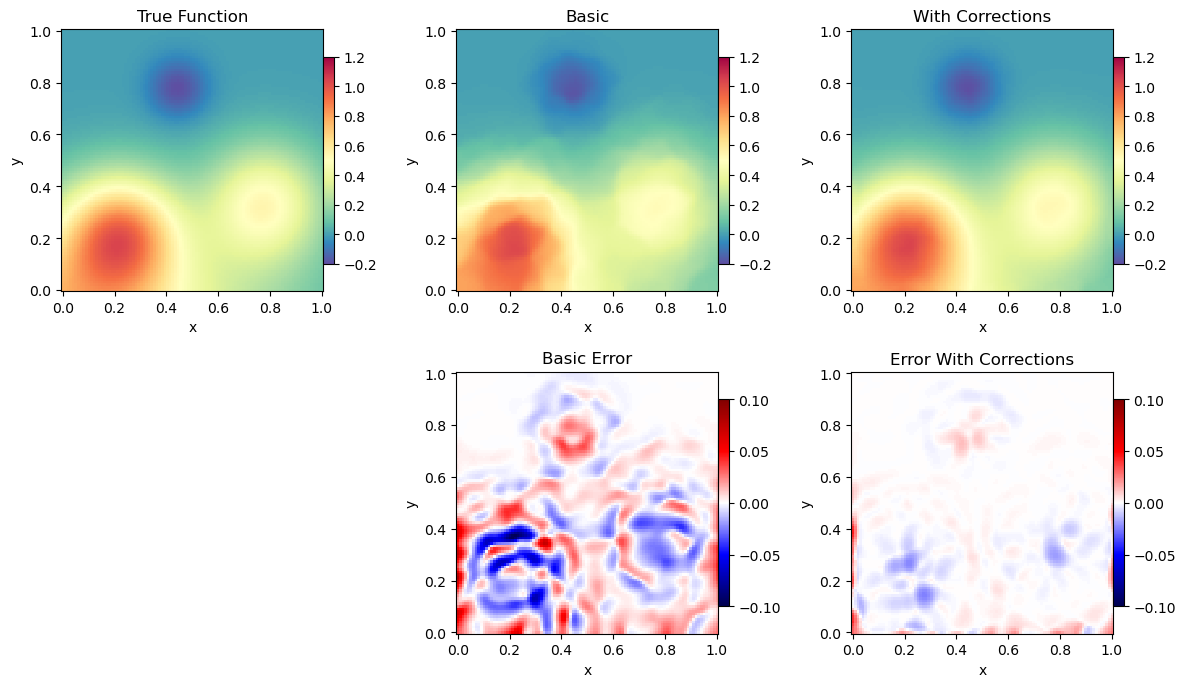


Error Statistics:
Basic - Max Error: 0.0967
Basic - RMS Error: 0.0156
With Corrections - Max Error: 0.0449
With Corrections - RMS Error: 0.0042


In [2]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7))

func_vmin, func_vmax = -0.2, 1.2
error_vmin, error_vmax = -0.1, 0.1

# Row 1: Function plots
im1 = axes[0, 0].pcolormesh(X, Y, f_true, cmap='Spectral_r', vmin=func_vmin, vmax=func_vmax)
axes[0, 0].set_title('True Function')

im2 = axes[0, 1].pcolormesh(X, Y, pred_basic_2d, cmap='Spectral_r', vmin=func_vmin, vmax=func_vmax)
axes[0, 1].set_title('Basic')

im3 = axes[0, 2].pcolormesh(X, Y, pred_corrected_2d, cmap='Spectral_r', vmin=func_vmin, vmax=func_vmax)
axes[0, 2].set_title('With Corrections')

# Row 2: Error plots
axes[1, 0].axis('off')

im5 = axes[1, 1].pcolormesh(X, Y, error_basic, cmap='seismic', vmin=error_vmin, vmax=error_vmax)
axes[1, 1].set_title('Basic Error')

im6 = axes[1, 2].pcolormesh(X, Y, error_corrected, cmap='seismic', vmin=error_vmin, vmax=error_vmax)
axes[1, 2].set_title('Error With Corrections')

cbar1 = fig.colorbar(im1, ax=axes[0, 0], shrink=0.75, pad=0)
cbar2 = fig.colorbar(im2, ax=axes[0, 1], shrink=0.75, pad=0)
cbar3 = fig.colorbar(im3, ax=axes[0, 2], shrink=0.75, pad=0)
cbar5 = fig.colorbar(im5, ax=axes[1, 1], shrink=0.75, pad=0)
cbar6 = fig.colorbar(im6, ax=axes[1, 2], shrink=0.75, pad=0)


for ax in axes.flat:
    if ax.get_visible():
        ax.set_aspect('equal')
        ax.set_xlabel('x')
        ax.set_ylabel('y')

plt.tight_layout()
plt.show()

print(f"\nError Statistics:")
print(f"Basic - Max Error: {np.max(np.abs(error_basic)):.4f}")
print(f"Basic - RMS Error: {np.sqrt(np.mean(error_basic**2)):.4f}")
print(f"With Corrections - Max Error: {np.max(np.abs(error_corrected)):.4f}")
print(f"With Corrections - RMS Error: {np.sqrt(np.mean(error_corrected**2)):.4f}")